In [1]:
%load_ext autoreload
%autoreload 2

import torch
from model import PointNet
from dataset import lm2flat_index
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import numpy as np

torch.backends.cudnn.benchmark = True

In [2]:
from typing import List, Tuple
from dataset import OctantDataset
from torch.utils.data import DataLoader
from pytorch3d.structures import Pointclouds
import torch.utils.data as data

ds = OctantDataset("../datasets/neuschwanstein_16_64max_sh",sub_sample=10000)

def collate_batched_point_clouds(batch: List[Tuple[Pointclouds, torch.Tensor]]):
    coefs = torch.stack([x[1] for x in batch])
    pcs = Pointclouds(
        points=[x[0].points_packed() for x in batch],
        features=[x[0].features_packed() for x in batch],
    )
    return (pcs, coefs)

num_train = int(0.8*len(ds))

ds_train, ds_val = data.random_split(ds,[num_train,len(ds)-num_train])

batch_size = 256

train_dataloader = DataLoader(
    ds_train, batch_size=batch_size, shuffle=True, collate_fn=collate_batched_point_clouds, drop_last=False,num_workers=12,pin_memory=True
)
val_dataloader = DataLoader(
    ds_train, batch_size=batch_size, shuffle=True, collate_fn=collate_batched_point_clouds, drop_last=False,num_workers=3,pin_memory=True
)
len(ds_train),len(ds_val)

(8000, 2000)

In [3]:
l = 5
model = PointNet((l + 1) ** 2,batch_norm=False).cuda()

sum(p.numel() for p in model.parameters() if p.requires_grad)


824748

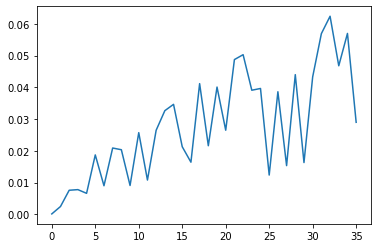

In [6]:
import numpy as np

coefs = torch.stack([ds[i][1][ : lm2flat_index(l, -l) + 1] for i in np.random.choice(len(ds),1000)])
avg_coefs = coefs.abs().permute(1,0,2).flatten(1).mean(1)
def weightedL2Loss(weights:torch.Tensor):
    def loss(prediction:torch.Tensor,target:torch.Tensor)->torch.Tensor:
        diff = prediction-target
        l2 = diff.square().sum(-1)
        return (l2*weights.to(prediction.device)).mean()
    return loss   

weighting = 1/avg_coefs
weighting /= weighting.sum() #normalize
mse_loss = weightedL2Loss(weighting)

plt.plot(weighting)

0it [00:00, ?it/s]

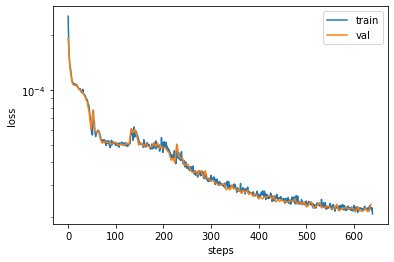

In [79]:
from torch.optim.lr_scheduler import OneCycleLR

epochs = 20

optimizer = torch.optim.AdamW(model.parameters(),lr=1e-3)

scheduler = OneCycleLR(optimizer,max_lr=1e-2,steps_per_epoch=len(train_dataloader),epochs=epochs,pct_start=0.3)

# mse_loss = torch.nn.MSELoss()

def unpack_data(pcs:Pointclouds):
    vertices = pcs.points_packed().cuda()
    color = (pcs.features_packed()[:, :3]).cuda().float() / 255.0
    batch = pcs.packed_to_cloud_idx().cuda()
    return vertices,color,batch


loss_hist_train = {}
loss_hist_val = {}
step=0

with tqdm(len(train_dataloader)) as pbar:
    for epoch in range(epochs):
        # print(f"lr: {scheduler.get_last_lr()}")

        pbar.reset(len(train_dataloader))
        pbar.set_description(f"epoch {epoch+1}/{epochs}")

        val_sampler = iter(val_dataloader)

        for i,(pcs, coefs) in enumerate(iter(train_dataloader)):
            model.train().requires_grad_(True)
            vertices,color,batch = unpack_data(pcs)
            target_coefs = coefs[:, : lm2flat_index(l, -l) + 1].cuda()
            optimizer.zero_grad()

            pred_coefs = model(vertices, color, batch)
            train_loss:torch.Tensor = mse_loss(pred_coefs, target_coefs)
            train_loss.backward()
            # torch.nn.utils.clip_grad_norm_(model.parameters(),max_norm=1.)
            optimizer.step()
            loss_hist_train[step] = train_loss.item()
            scheduler.step()

            # do validation batch every 4th train batch
            if i%4 == 0:
                model.eval()
                pcs,coefs = next(val_sampler)
                vertices,color,batch = unpack_data(pcs)
                target_coefs = coefs[:, : lm2flat_index(l, -l) + 1].cuda()
                pred_coefs = model(vertices, color, batch)
                val_loss:torch.Tensor = mse_loss(pred_coefs, target_coefs)
                loss_hist_val[step] = val_loss.item()

            pbar.update()
            step+=1

plt.plot(loss_hist_train.keys(),loss_hist_train.values(), label="train")
plt.plot(loss_hist_val.keys(),loss_hist_val.values(), label="val")
plt.legend()
plt.xlabel("steps")
plt.ylabel("loss")
plt.yscale("log")


In [23]:
torch.save(model.state_dict(),"../model/model.pt")

In [80]:
from sh import calc_sh

res = 100
x = torch.arange(0,1,1/res)
grid_x,grid_y = torch.meshgrid(x*torch.pi,x*2*torch.pi,indexing="ij")
coords = torch.stack((grid_x.flatten(),grid_y.flatten())).T

y = calc_sh(l,coords)

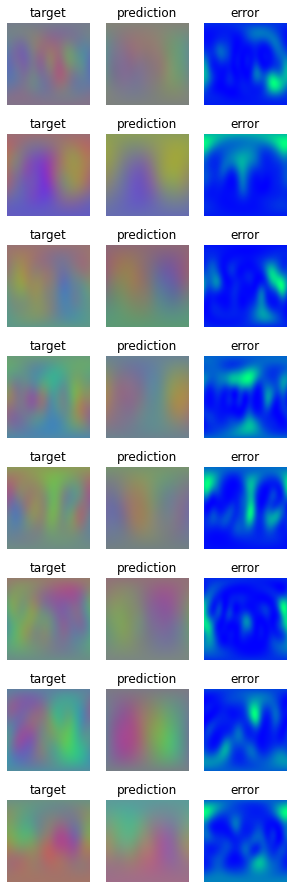

In [86]:
model.eval()
model.requires_grad_(False)

pc,a_lm = next(iter(train_dataloader))

pred_a = model(*unpack_data(pc)).squeeze(0)
a_lm = a_lm[:,:lm2flat_index(l, -l) + 1]

fig,axes = plt.subplots(8,3,figsize=(5,16))

for i in range(8):
    ax1,ax2,ax3 = axes[i]
    ax1.set_title("target")
    ax1.set_axis_off()

    target = (y@a_lm[i].cpu()).reshape(res,res,-1).clip(0,1)
    ax1.imshow(target)

    ax2.set_title("prediction")
    ax2.set_axis_off()
    prediction =(y@pred_a[i].cpu()).reshape(res,res,-1).clip(0,1)
    ax2.imshow(prediction)

    ax3.set_title("error")
    ax3.set_axis_off()
    error = (prediction-target).square().mean(-1)
    ax3.imshow(error,cmap="winter")

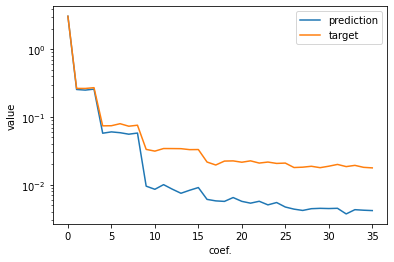

In [87]:
plt.ylabel("value")
plt.xlabel("coef.")
# plt.plot((a_lm-pred_a.cpu()).norm(2,-1).mean(0),label="error")
plt.plot((pred_a.cpu()).norm(2,-1).mean(0),label="prediction")
plt.plot((a_lm.cpu()).norm(2,-1).mean(0),label="target")
plt.legend()
plt.yscale("log")

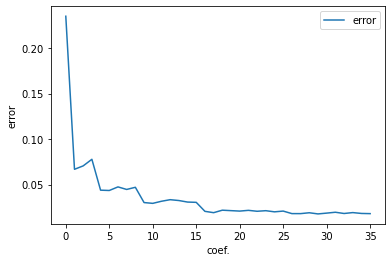

In [88]:
plt.ylabel("error")
plt.xlabel("coef.")
plt.plot((a_lm-pred_a.cpu()).norm(2,-1).mean(0),label="error")
plt.legend()
# plt.yscale("log")

In [89]:
sizes = [ds[i][0].num_points_per_cloud().item() for i in np.random.choice(len(ds),10000)]

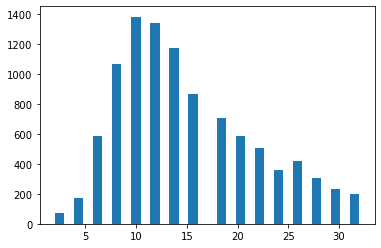

In [90]:
from torch.distributions.beta import Beta

plt.hist(sizes,bins=32)
x = np.arange(0,1,0.01)
# plt.plot(x*64,normal_df(x,0.35,0.11)*100)
plt.show()
# bins.max(),bins.min()

In [7]:
all_points = torch.cat([ds[i][0].points_packed() for i in np.random.choice(len(ds),10000)])

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/niedermayr/anaconda3/envs/punctum/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3369, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_56173/637864256.py", line 1, in <cell line: 1>
    all_points = torch.cat([ds[i][0].points_packed() for i in np.random.choice(len(ds),10000)])
  File "/tmp/ipykernel_56173/637864256.py", line 1, in <listcomp>
    all_points = torch.cat([ds[i][0].points_packed() for i in np.random.choice(len(ds),10000)])
  File "/home/niedermayr/punctum/pointnet/dataset.py", line 54, in __getitem__
    return self.load_ply(self.ply_files[idx])
  File "/home/niedermayr/punctum/pointnet/dataset.py", line 47, in load_ply
    pc = Pointclouds(
  File "/home/niedermayr/anaconda3/envs/punctum/lib/python3.9/site-packages/pytorch3d/structures/pointclouds.py", line 238, in __init__
    features_parsed = self._parse_auxiliary_input(features)
  File "/home/niedermayr/anaco

In [100]:
res = 100
coords = ((all_points + 1)/2 * (res-1)).int()
pos,count = coords[:,[0,1]].unique(return_counts=True,dim=0)

heatmap = torch.zeros((res*res),dtype=torch.long)

heatmap[(pos[:,1]*res+pos[:,0]).long()] = count

plt.imshow(heatmap.reshape(res,res))


IndexError: index -2147483648 is out of bounds for dimension 0 with size 10000

In [107]:
all_points[all_points.isnan().any(-1)]

tensor([[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]])

In [108]:
all_features = torch.cat([ds[i][0].features_packed() for i in np.random.choice(len(ds),10000)])